# Тест №4. Только перенос, тест сходимости

In [54]:
%load_ext autoreload
%autoreload 2

from state import State, GridField
from domain import Domain
from swe_operators import SweAdvectiveFormOperator, SweOnlyAdvection
from time_schemes import rk4, explicit_euler
from initial_conditions import gaussian_hill, barotropic_instability, geostrophic_balance, gaussian_hill_1rotor, gaussian_hill_2rotor
from diffusion import DiffusionOperator, diff2_sbp21
import operators as op
from vizualization import trisurf_field, animate_trisurf, surf_interpolated_field, animate_interpolated_surf, \
                          animate_tripcolor, tripcolor_field, imshow_interpolated_field

import numpy as np
from vecmath import calc_mass
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# definition of computational domain constants
RADZ = 6371.22 * 1000.0 # "Earth" radii in meters
GRAV = 9.80616 # "Earth" gravity acceleration in m * s**(-2)
OMEGA = 7.292 * 10**(-5) # "Earth" angular velocity in rad * s**(-1)
PCORI = 2 * OMEGA # Coriolis parameter
H_MEAN = 10 * 1000.0 # "Earth" mean atmosphere depth
C_GRAV = np.sqrt(GRAV * H_MEAN) # Gravity wave speed
LX = 2 * np.pi * RADZ # domain size [0, LX] x [0, LY]
LY = 2 * np.pi * RADZ # domain size [0, LX] x [0, LY]

In [80]:
%%time
import time
from IPython.display import display, clear_output

domains = [Domain(xs = 0.0,    xe = LX / 2, nx = 32 * 2, ys = 0.0, ye = LY, ny = 64,  lx=LX, ly=LY), \
           Domain(xs = LX / 2, xe = LX    , nx = 32, ys = 0.0, ye = LY, ny = 64,  lx=LX, ly=LY)]

state = gaussian_hill_2rotor(domains, H_MEAN)
swe_operator = SweOnlyAdvection(g=GRAV, pcori=0.0, diff_method = op.diff_sbp42)

T = 10 * 24 * 3600
Nt = 16 * 120
dt = T / Nt

diff_coeffs = [domains[0].dx ** 2 / dt, domains[0].dx ** 2 / dt]
diff = DiffusionOperator(diff_coeffs, diff2_method = diff2_sbp21)

states_list = [state]
for k in range(Nt+1):
    clear_output(wait=True)
    display('Time step '+str(k))
    state = rk4(state, swe_operator, dt, domains)
    state = explicit_euler(state, diff, dt, domains)
    states_list.append(state)
h_list = [state.h for state in states_list]

'Time step 1920'

CPU times: user 28.7 s, sys: 3.46 s, total: 32.1 s
Wall time: 30.6 s


<IPython.core.display.Javascript object>


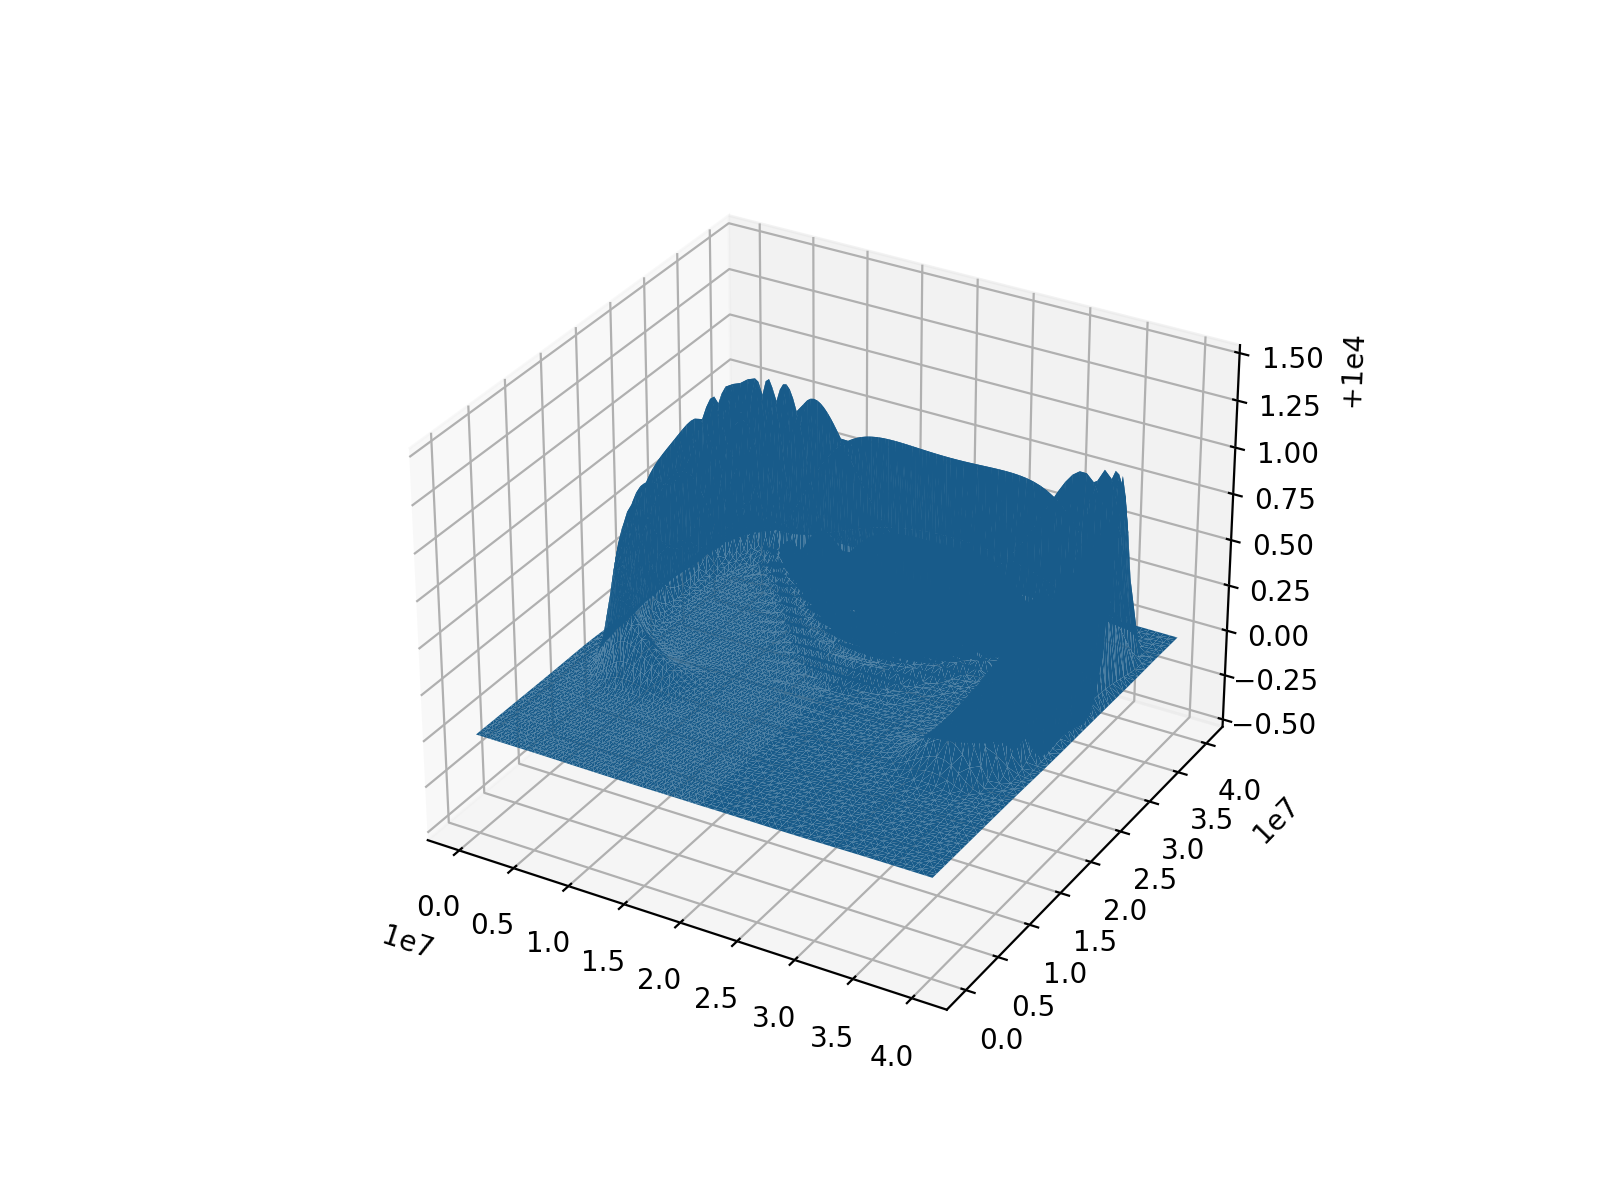

In [81]:
animate_trisurf(h_list, domains, 10)

<IPython.core.display.Javascript object>


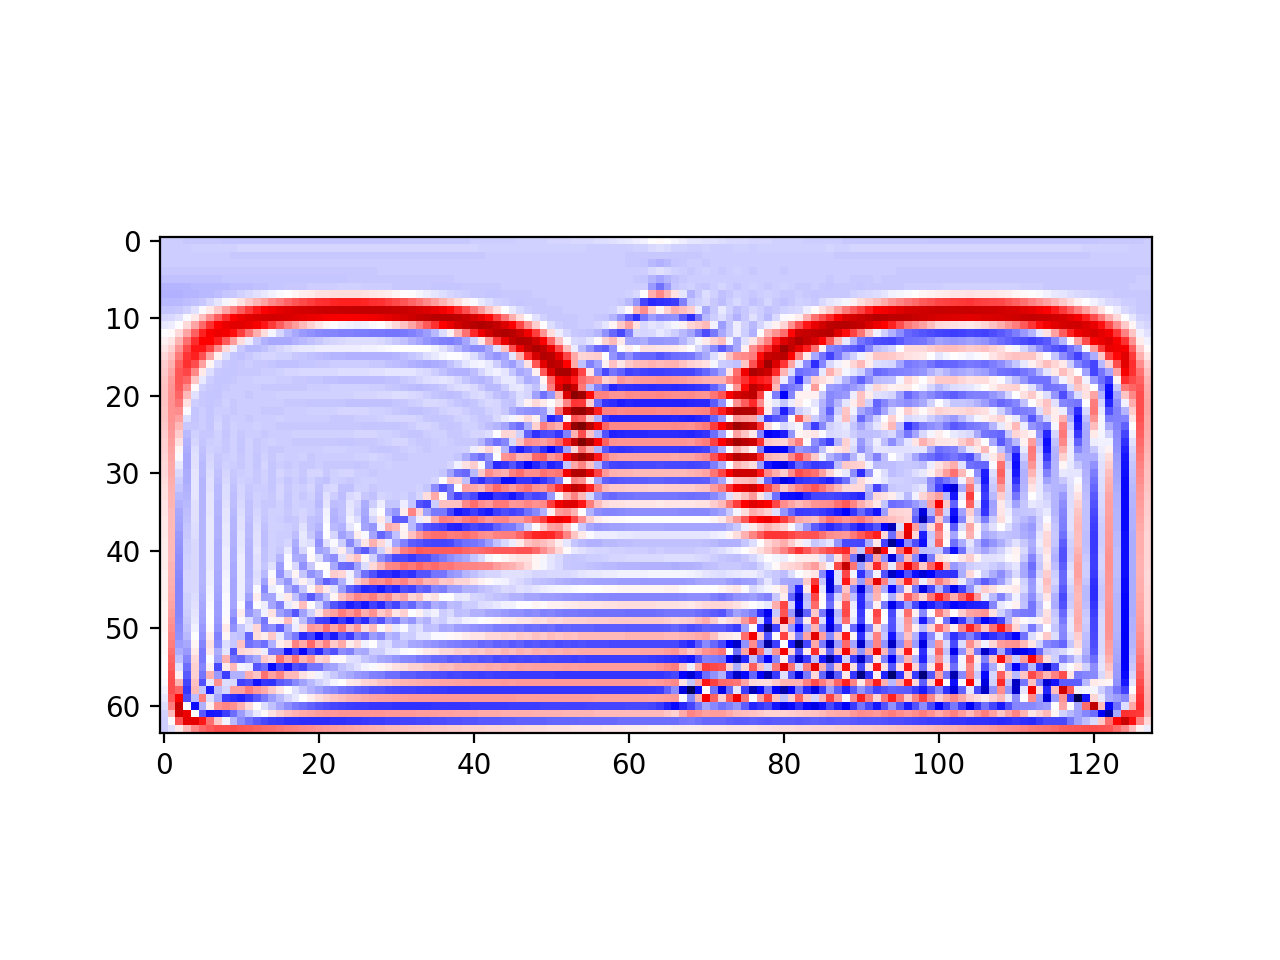

In [78]:
imshow_interpolated_field(h_list[1600], domains, False, None)